In [1]:
import spotipy
import spotipy.util as util
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import time
import seaborn as sns
import numpy as np
import itertools

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, hamming_loss
from collections import Counter

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


'''Get user token to access Spotify API. Token is refreshed periodically.'''

# Credentials for Spotify API
username = '1242062883'
client_id ='e6265a912d9c4be18688eee8093bb4e8'
client_secret = 'fc27bdc4c3654450960bbb60c38b3fd0'
scope = 'playlist-read-private playlist-modify-private user-read-private'

# Credentials for Deezer API
deezer_client_id = '446462'
deezer_client_secret = 'fea9e6460c9d476297b1144853140c8e'

redirect_uri = 'http://localhost:7777/callback'

In [2]:
'''TODO - Instantiate Flask server with dash and build web application'''
from flask import Flask
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import os
import os.path
from os import path
import chart_studio.plotly as py
from flask_sqlalchemy import SQLAlchemy
import sqlalchemy

server = Flask(__name__)


## API Helper Functions
The following functions help me do Spotify and Deezer API calls to pull raw data, dimensionality reduce, and transform the data to prepare my dataset for exploration and model building. They are listed in the approximate order they are called, and build on each other to enable my store_data() and get_data() functions, which store and load my complete training dataset. Function details are included in the comments.

API Calls:
- get_playlist_track_ids(): Run a keyword search in Spotify to return all track ids from n playlists searched
- get_track_artist_album(): Get a track title, album, and artist given a Spotify track id
- get_deezer_album_id(): Get a Deezer album id given track title, album, and artist obtained from get_track_artist_album()
- get_deezer_album_genres(): Calls get_deezer_album_id to get Deezer album ids, then gets Deezer album genres for those ids
- get_genres(): Call get_playlist_track_ids() and get_deezer_album_genres() to compile dataframe with Spotify track ids and genres
- get_audio_features(): Using Spotify track id's from get_playlist_track_ids(), get audio features for each track via Spotify API
- search_and_label(): Takes in list of user's desired playlist names, then passes them as keyword queries to Spotify API using get_playlist_track_ids() to return dataframe of track id's labeled with the playlist name that returned them

Data Storage, Extract, and Transformation:
- store_data(): Calls search_and_label(), get_audio_features(), and get_genres() to assemble a dataframe with track features, genres, and labels to store. Currently passes output to csv, but will eventually store to CloudSQL database
- get_data(): Retrieves data stored using store_data(). Can be used to get data for any or all playlist names stored
- binarize(): Used only to prepare data for modeling. Categorical features and labels are stored and retrieved in one column per variable, so binarize() calls pandas get_dummies() to binarize categorical data for use model



In [3]:
def get_playlist_track_ids(search_string, num_entries) -> str:
    '''
    Parameters:
        - search_string (name of the playlist you want to create)
        - num_entries (number of public playlists in Spotify you want to extract songs from)
        
    Function: Query Spotify API using search string to return list of playlists. Once
    playlists are obtained, use another API GET request for each playlist to extract its track ids.
    
    Note: Adjusting num_entries has the largest impact on the dataset in terms of sample size. You are
    effectively getting num_entries opinions from the Spotify user base on which songs belong in which
    types of playlist. Higher num_entries = more robust results
    
    Return: unique track ids from all playlists (list format)
    '''

    # Spotify API can only query up to 50 entries at a time, so to get > 50 entries,
    # need to run a new entry that is offset by the number of entries that have already been returned
    limit = 50
    num_queries = math.ceil(num_entries / limit)

    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }

    playlist_ids = []
    
    # Iteratively perform keyword search for playlists using Spotify API, increasing offset by 50 each round
    for i in range(num_queries):
        params_pl = [
        ('q', search_string),
        ('type', 'playlist'),
        ('limit', str(limit)),
        ('offset', str(i * limit))
        ]
        try:
            response = requests.get('https://api.spotify.com/v1/search', 
                        headers = headers, params = params_pl, timeout = 5)
            json = response.json()
            for playlist in json['playlists']['items']:
                playlist_ids.append(playlist['id'])
        except:
            print('Playlist search failure')
            return None
    
    # Run a new Spotify API query for each playlist ID to get list of song ID's in that playlist
    track_ids = []
    for playlist_id in playlist_ids:
        try:
            response = requests.get('https://api.spotify.com/v1/playlists/' + playlist_id + '/tracks', 
                        headers = headers, timeout = 5)
            json = response.json()
            for item in json['items']:
                track_ids.append(item['track']['id'])
        except:
            continue
    return list(set(track_ids))

In [4]:
def get_track_artist_album(track_ids):
    '''
    Parameters:
        - track_ids: list of Spotify track ids obtained from get_playlist_track_ids
        
    Function: Spotify API GET request using track id list to get corresponding
    track names and artists
    
    Return: list of dictionaries where each entry contains track artist, track album, and track name
    '''

    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    
    limit = 50
    num_queries = math.ceil(len(track_ids) / limit)
    tracks_aan = []

    for i in range(num_queries):
        start = i*50
        end = start + 50
        if len(track_ids[start:]) >= 50:
            id50_segment = track_ids[start:end]
        else:
            id50_segment = track_ids[start:]
        
        try:
            id50_segment_query = ','.join(id50_segment)
        except:
            try:
                for track_id in id50_segment:
                    if track_id is None:
                        id50_segment.remove(track_id)
                id50_segment_query = ','.join(id50_segment)
            except:
                continue
   
        params_aan = [('ids', id50_segment_query)]

        try:
            response = requests.get('https://api.spotify.com/v1/tracks/', 
                    headers = headers, params=params_aan, timeout = 5)
            json = response.json()
            index = 0
            for track in json['tracks']:
                tracks_aan.append({'track_id': id50_segment[index], 
                                   'artist': track['album']['artists'][0]['name'], 
                                   'album': track['album']['name'], 
                                   'track': track['name']})
                index += 1
        except:
            print('AAN search failure')
            continue

    return tracks_aan

In [5]:
def get_deezer_album_id(tracks_info, album_id_list):
    '''
    Parameters:
    - tracks_info: List of track dicts, each entry contains track_id, artist, album, and track
    - album_id_list: Empty list for storing album IDs

    Function: Use get_track_artist_album() to get Spotify track, artist, and album for each track_id obtained through 
    initial get_playlist_track_ids keyword search, then use track, artist, and album as query parameters in 
    the Deezer API to get corresponding Deezer album ID. Append result to album_id_list, which is passed in
    as a parameter and becomes a list of dicts with each entry containing a Spotify track id and a corresponding 
    Deezer album id.

    Return: N/A
    '''
    
    spotify_token = token
    deezer_token = deezer_client_secret

    search_url = "https://api.deezer.com/search"

    headers = {
    'Accept': 'application/json',
    'response-type': deezer_token
    }

    for track in tracks_info:
        querystring = "artist:\"{0}\" album:\"{1}\" track:\"{2}\"".format(track['artist'], 
                                                                          track['album'], 
                                                                          track['track'])
        params = [('q', querystring)]
        try:
            response = requests.get(search_url, headers=headers, params=params)
            data = response.json()
            album_id_list.append({'spot_track_id': track['track_id'],
                                    'deezer_album_id': str(data['data'][0]['album']['id'])})
        except:
            continue

In [6]:
def get_deezer_album_genres(deezer_album_ids, genres_list):
    '''
    Parameters:
    - deezer_album_id: List of dicts containing Spotify track ID and corresponding Deezer album ID
    - genres_list: empty list for storing album IDs 
    
    Function: Use Deezer album ID to get the genre of the album that a given 
    track (indicated by track id) belongs to from the Deezer API. Append to genres_list,
    which is passed in as a parameter and becomes a list of dicts with each entry containing
    a Spotify track id and the genre of the album it belongs to. 
    
    Return: None
    '''
    
    deezer_token = deezer_client_secret
    headers = {
        'Accept': 'application/json',
        'response-type': deezer_token
        }

    for entry in deezer_album_ids:
        album_url = "https://api.deezer.com/album/" + entry['deezer_album_id']
        track_id = entry['spot_track_id']
        try:
            response = requests.get(album_url, headers=headers)
            data = response.json()
            genres_list.append({'trackid': track_id, 
                                'genre': data['genres']['data'][0]['name']})
        except:
            continue

In [7]:
def get_genres(track_ids):
    '''
    Parameters:
    - track_ids

    Function: Get Spotify track information (track name, artist, album) from Spotify track_id, then run
    subfunctions to search for Deezer album id, then corresponding album genre from Deezer
    to identify the genre of a given track

    Return: Pandas dataframe with Spotify track id as key and corresponding track genre as value. To
    be joined with master dataset.
    '''
    
    track_info = get_track_artist_album(track_ids)
    album_ids = []
    genres_list = []
    get_deezer_album_id(track_info, album_ids)
    get_deezer_album_genres(album_ids, genres_list)
    
    genres_df = pd.DataFrame(columns=['trackid', 'genre'])
    for genre in genres_list:
        genres_df = genres_df.append(genre, ignore_index=True)
    return genres_df


In [8]:
def get_audio_features(track_ids):
    '''
    Parameters:
        - List track_ids to get audio features for
        
    Function: Call Spotify API to get audio features for all track_ids passed in. Pings Spotify API
    for 100 songs at a time (limit) to make queries faster.
    
    Return: Dataframe of track ID's with features. To be joined with master dataset.
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4|...
    --------+--------+--------+--------+--------+...
    1efae1j |   0.4  |    2   |   1.4  |  0.23  |...
    '''
    
    sp = spotipy.Spotify(auth=token)
    try:
        feature_columns = [
            'trackid',
            'danceability', 
            'energy', 
            'loudness', 
            'speechiness', 
            'acousticness', 
            'instrumentalness', 
            'liveness', 
            'valence', 
            'tempo']
        features_df = pd.DataFrame(columns=feature_columns)
        num_iter = math.ceil(len(track_ids)/100)
        i = 0
        for i in range(num_iter):
            start = i*100
            end = start + 100
            # Generate a 100-element long segment of the features_df each iteration
            if len(track_ids[start:]) >= 100:
                try:
                    features_df_segment = sp.audio_features(track_ids[start:end])
                except:
                    continue
            else:
                features_df_segment = sp.audio_features(track_ids[start:])
            
            id_index = i*100 

            for features in features_df_segment:
                try:
                    features_filtered = {key:features[key] for key in feature_columns if key in features}
                    audio_features = {'trackid': track_ids[id_index]}
                    audio_features.update(features_filtered)   
                except:
                    continue
                
                try:
                    features_df = features_df.append(audio_features, ignore_index=True)
                except:
                    print(id_index)
                    
                id_index += 1
            
            i += 1            
        
        return features_df
        
    except:
        print('Error occurred during audio feature extraction')
        return None

In [9]:
def search_and_label(pl_name, num_pl_search):
    '''
    Parameters:
        - pl_name: Playlist name user wants to create, passed into keyword search in get_playlist_track_ids()
        - num_pl_search: Max # of playlists to return per keyword search using get_playlist_track_ids()
        
    Function: Run a Spotify API keyword search for playlists matching the pl_name using get_playlist_track_ids(), 
    then store all of the songs from each playlist by track id. Keeps track of which keyword search 
    the song came from in the labels column.
    
    Return: Dataframe containing class labels. Labels are not mutually exclusive. To be joined with
    master dataset.
    
    Dataframe format: 
    trackid | label
    --------+--------
    1efae1j | hip hop
    12fae31 | vibey
    ...     | ...

    '''
    
    song_labels = pd.DataFrame(columns=['trackid', 'label'])

    queried_track_ids = get_playlist_track_ids(pl_name, num_pl_search)
    
    for track_id in queried_track_ids:
        try:
            search_result = {'trackid': track_id, 'label': pl_name}
            song_labels = song_labels.append(search_result, ignore_index=True)
        except:
            continue

    return song_labels

In [10]:
def store_data(pl_name, num_pl_search):
    '''
    Parameters:
        - pl_name: Playlist name user wants to create, passed into search_and_label()
        - num_pl_search: Max # of playlists to return per keyword search, passed into search_and_label()
        
    Function: Get all unique playlist names that are already in data store, and only proceed with function
    if the input pl_name is not already in this list. Call search_and_label() to get track ids and labels, then call
    get_audio_features() on track ids to get features. Finally, call get_genres() to get the Deezer genre for each 
    song. Merge the three dataframe outputs on track_id to get complete dataset, then store to csv file. For future 
    plotly-dash module, this will save to CloudSQL database instead. 
    
    Return: True if csv is written successfully
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4|   label    |     genre     
    --------+--------+--------+--------+--------+------------+-------------
    1e3ae1j |   0.4  |    2   |   1.4  |  0.23  |  90s rock  |  alternative
    '''
    t0 = time.time()
    
    # ----- REPLACE WITH SQL SELECT UNIQUE label FROM [tableName] LOGIC HERE -----
    
    if path.exists('trackdata.csv'):
        existing_data = pd.read_csv('trackdata.csv')
        stored_pls = list(set(existing_data['label'].to_list()))
        
        if pl_name in stored_pls:
            print('{0} already exists in dataset'.format(pl_name))
            return True
            
    # For loop - filter out playlists from pl_names that are already in database
    # If len(filtered_pl_names) > 0, proceed with function
    
    # ----- END ---------------------
    print('Starting data store for new label: {0}'.format(pl_name))
    track_labels = search_and_label(pl_name, num_pl_search)
    track_ids = track_labels['trackid'].to_list()
    track_features = get_audio_features(track_ids)
    track_genres = get_genres(track_ids)

    track_data = pd.concat([track_features, track_labels, track_genres], join='inner', axis=1)
    track_data.reset_index()
    track_data = track_data.loc[:,~track_data.columns.duplicated()]
   
    try:
        # ----- REPLACE WITH SQL INSERT INTO [tableName] LOGIC HERE -----
        
        if path.exists('trackdata.csv'):
            track_data.to_csv('trackdata.csv', mode='a', header=False, index=False)
        else:
            track_data.to_csv('trackdata.csv', mode='w', header=True, index=False)

        # ----- END ---------------------
        
        t1 = time.time()
        print('Success: {0} unique tracks with features and labels obtained in {1} seconds'.format( \
              len(track_data.trackid.unique()), (t1-t0)))

        return True
    
    except:
        print ('Error: CSV write failure')
        return False

In [11]:
def get_data(pl_names):
    '''
    Parameters:
        - pl_names: List of labels user wants to include in exploration and model building

    Function: Get data from data store, filtered to the list of playlists desired based on 
    the entries in pl_names. Load output into Pandas dataframe.
    
    Return: Dataframe of track ID's with features and labels filtered by pl_names input.
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4| genre  |      label     
    --------+--------+--------+--------+--------+--------+----------------
    1e3ae1j |   0.4  |    2   |   1.4  |  0.23  |  rock  |  classic rock  
    '''
    
    t0 = time.time()
    
    # --- REPLACE WITH SELECT * FROM [tableName] HERE ---
    
    data = pd.read_csv('trackdata.csv')

    # --- END ---
    
    filtered_data = data[data['label'].isin(pl_names)]
    features = [
            'danceability', 
            'energy', 
            'loudness', 
            'speechiness', 
            'acousticness', 
            'instrumentalness', 
            'liveness', 
            'valence', 
            'tempo']

    t1 = time.time()

    print('{0} records obtained in {1} seconds'.format(len(filtered_data.index), t1-t0))

    return {'data': filtered_data, 'features': features, 'playlists': pl_names}

In [12]:
def binarize(df, feature_var, label_var, id_col):
    '''
    Parameters:
        - df: dataframe extracted using get_data() 
        - feature_var: categorical feature variable to be binarized
        - label_var: categorical label to be binarized
        - id_col: name of unique track id column

    Function: Pass df, feature_var, and label_var as parameters to Pandas get_dummies()
    method to binarize feature_var and label_var into dummy variables. Then use id_col in
    groupby().max() method to account for tracks that belong to more than one feature
    or label category.
    
    Return: Binarized dataframe with new columns for each dummy variable generated. Columns
    are named according to the original name of the category value.
    
    Dataframe format: 
    trackid |feature1|feature2|feature3|feature4| genre_rock |  genre_pop  | label_country | label_90s jams 
    --------+--------+--------+--------+--------+------------+-------------+---------------+----------------
    1e3ae1j |   0.4  |    2   |   1.4  |  0.23  |     1      |     0       |       0       |        1       
    '''

    feature_var_values = list(set(df[feature_var].tolist()))
    new_feature_var_values = [feature_var + '_' + value for value in feature_var_values]

    label_var_values = list(set(df[label_var].tolist()))
    new_label_var_values = [label_var + '_' + value for value in label_var_values]

    binarized_data = pd.get_dummies(data=df, columns=[feature_var, label_var])
    binarized_data = binarized_data.groupby([id_col], as_index=False).max()

    return {'data': binarized_data, feature_var: new_feature_var_values, label_var: new_label_var_values}

<h1><u> Get Data here</u></h1>

In [13]:
# User-generated list of playlist names (hardcoded for development / testing)
pl_names = ['electronic dance music', 'indie folk music', 'hip hop', 'classic rock', 'chill lofi', 'classical', 'country']

for name in pl_names:
    token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')
    store_data(name, 100)

electronic dance music already exists in dataset
indie folk music already exists in dataset
hip hop already exists in dataset
classic rock already exists in dataset
chill lofi already exists in dataset
classical already exists in dataset
country already exists in dataset


In [14]:
data_pulled = get_data(['electronic dance music', 'indie folk music', 'classic rock'])

13262 records obtained in 0.1356358528137207 seconds


In [15]:
data = data_pulled['data'].drop('trackid', axis=1)
data_wtrackid = data_pulled['data']
playlists = data_pulled['playlists']
features = data_pulled['features']
data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,label,genre
0,0.726,0.887,-5.242,0.0972,0.0617,0.00478,0.3260,0.5170,123.965,electronic dance music,Electro
1,0.587,0.734,-5.603,0.0581,0.0183,0.02520,0.4310,0.0825,131.891,electronic dance music,Dance
2,0.720,0.604,-6.079,0.0343,0.3280,0.00140,0.3440,0.3170,126.037,electronic dance music,Electro
3,0.817,0.779,-6.387,0.1640,0.0262,0.90800,0.0995,0.6030,125.040,electronic dance music,Electro
4,0.558,0.886,-4.121,0.0891,0.6160,0.00000,0.1220,0.5790,107.995,electronic dance music,Dance


### Data Exploration
Many of the graphs here will be used in the actual app data visualization to help the user understand how well-separated the playlists being chosen are in terms of features, so they know how well the model will work

Ideas:
- Compare of genre breakdowns between classes - understand how well genre distribution differentiates classes selected 
- Class size comparison - get overall sense of how well balanced the dataset is
- Compare average Spotify feature values across playlists for each feature (radar chart) - clear visual representation of how features differ on average between classes
- Compare spread across features for each playlist (kde dist plot) - see how similar distributions of features are between classes. May want to quantify using bootstrap sampling as well (null hypothesis: between two classes, the values for a given feature belong to the same distribution).
- Count how many overlaps each playlist had with the other playlists (2^n - n possible combinations) - another similarity measure between playlists
- Check multicollinearty between features using correlation matrix - ensure features don't correlate strongly with each other, as this is an assumption in most of the models I plan to try.

In [16]:
# Set theme
sns.set(style="whitegrid")

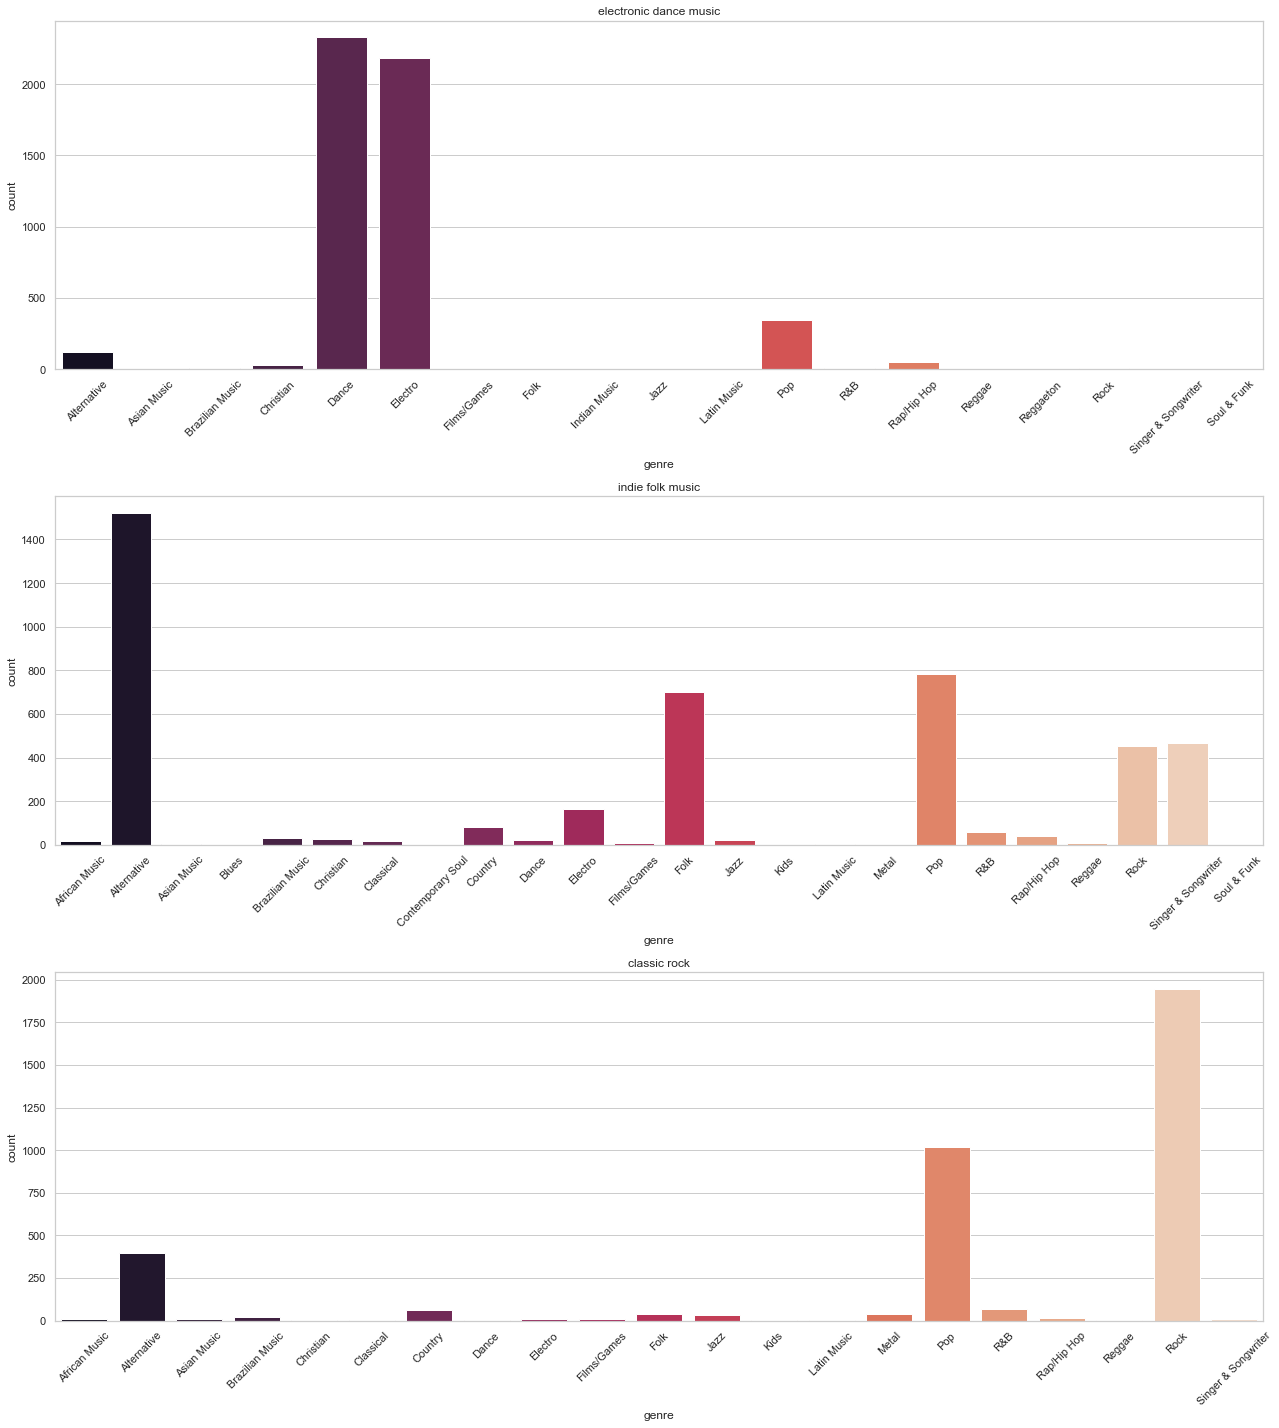

In [17]:
''' Genre breakdown '''
fig, ax = plt.subplots(len(playlists), 1, figsize=(18, 20))

row = 0

for pl in playlists:
    genre_graph_data = data[data['label']==pl].groupby('genre', as_index=False).agg(
        count=pd.NamedAgg(column='genre', aggfunc='count')
    )
    plot = sns.barplot(ax=ax[row], x='genre', y='count', data=genre_graph_data, palette='rocket')
    ax[row].set_title(pl)
    for item in plot.get_xticklabels():
        item.set_rotation(45)
    row += 1
plt.tight_layout()
plt.show()

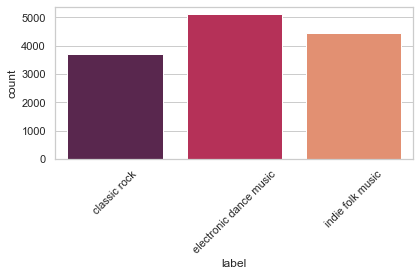

In [18]:
''' Barplot of class sizes '''
class_sizes = data.groupby('label', as_index=False).agg(
    count=pd.NamedAgg(column='label', aggfunc='count')
)

plot = sns.barplot(x='label', y='count', data=class_sizes, palette='rocket')
for item in plot.get_xticklabels():
        item.set_rotation(45)
plt.tight_layout()

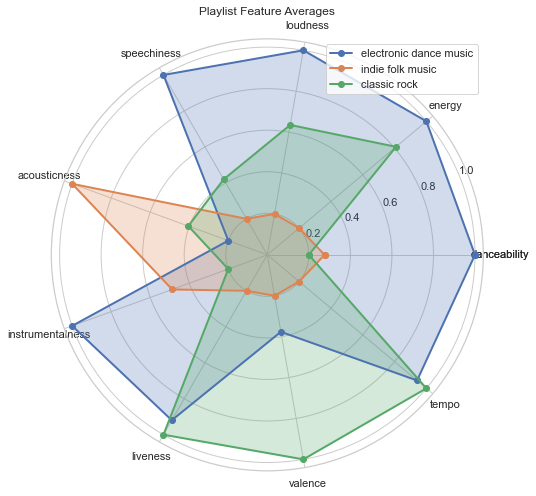

In [19]:
'''
Radar chart to compare average feature values between playlists

Generate dataframe with n rows for n playlists and feature values in the columns.
1. Reshape dataframe so each row has a playlist name of a song with the song's features
2. Take the mean for each column within the playlist name
3. Normalize the columns for each feature

playlist | feature 1 | feature 2 | feature 3 | ... 
---------+-----------+-----------+-----------+ ...
pl_1     |    0.5    |    0.8    |    0.9    | ...

'''

pls_df = pd.DataFrame(columns = ['label'] + features)

for item in playlists:
    pl_df = data[data['label']==item]
    pl_df = pl_df[['label'] + features]
    pl_averages = pl_df.groupby('label', as_index=False).mean()
    pls_df = pls_df.append(pl_averages, ignore_index=True)

scaler = MinMaxScaler(feature_range=(0.2, 1))

pls_df_scaled = pd.DataFrame(columns = ['label'] + features)
pls_df_values_scaled = scaler.fit_transform(pls_df[features].values)

i = 0
for row in pls_df_values_scaled:
    pls_df_scaled_row = dict(zip(features, row))
    pls_df_scaled_row['playlist'] = playlists[i]
    pls_df_scaled = pls_df_scaled.append(pls_df_scaled_row, ignore_index=True)
    i+=1

fig = plt.figure()
ax = fig.add_axes([0.30, 0.2, 1.5, 1.5], polar=True)
labels = np.array(features)

for index, row in pls_df_scaled.iterrows():
    stats = pls_df_scaled.loc[index, labels].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, np.array(features + [features[0]]))
    ax.legend(playlists)
    ax.grid(True)

plt.title('Playlist Feature Averages')
plt.show()

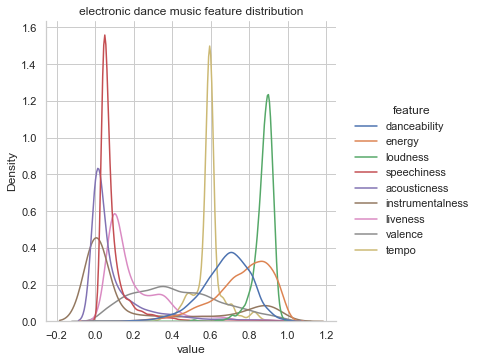

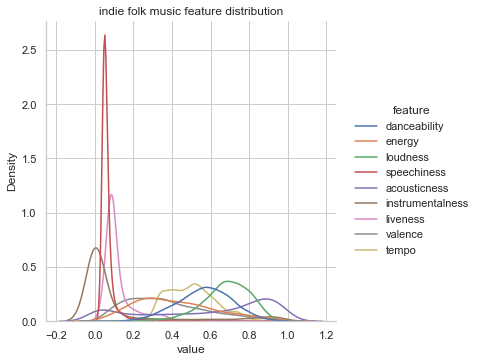

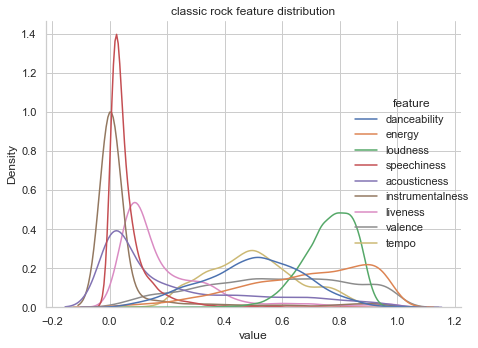

In [20]:
'''
Compare spread across features for each playlist (4 total prob density function plots)

For each playlist, plot the following dataframe format (plot each track individually):
feature | value

This requires normalization of feature values using sklearn.preprocessing
'''
scaler = MinMaxScaler()

for pl in playlists:
    pl_features_df = pd.DataFrame(columns=['feature', 'value'])
    for feature in features:
        # Scale values first!
        pl_features = data[data['label']==pl][feature].to_numpy().reshape(-1, 1)
        pl_features = pd.DataFrame(scaler.fit_transform(pl_features))
        pl_features['feature'] = feature
        pl_features.columns = ['value', 'feature']
        pl_features_df = pl_features_df.append(pl_features, ignore_index=True)
    
    sns.displot(x='value', data=pl_features_df, hue='feature', kind='kde')
    plt.title(pl + ' feature distribution')

plt.tight_layout()
plt.show()


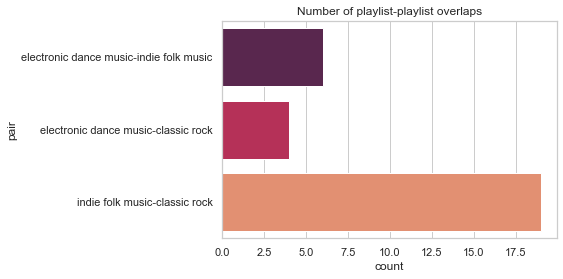

In [21]:
'''
Overlap summary graph: Count how many times each playlist overlaps with another playlist (n(n-1)/2 possible combinations)
Requires generation of all possible length-2 combinations of the playlists selected, filtering to instances where those combinations occur, then counting those instances
'''

n_playlists = len(playlists)
n_pairs = int(n_playlists*(n_playlists-1)/2)

# pair_inds generates all possible length-2 combinations of matches by list index in pl_names
pair_inds = list(set((itertools.combinations(list(range(n_playlists)), 2))))

pairs = [[playlists[pair_ind[0]], playlists[pair_ind[1]]] for pair_ind in pair_inds]

pairs_df = pd.DataFrame(columns=['pair', 'count'])

overlap_data = data_wtrackid.groupby('trackid', as_index=False)['trackid', 'label'].transform(lambda x: ''.join(x)).drop_duplicates()

for pair in pairs:
    pair_name = pair[0] + '-' + pair[1]
    pair_filter = (overlap_data['label'].str.contains(pair[0])) & \
                  (overlap_data['label'].str.contains(pair[1]))
    pair_count = len(overlap_data[pair_filter].index)
    pairs_df = pairs_df.append({'pair': pair_name, 'count': pair_count}, ignore_index=True)

ax = sns.barplot(x='count', y='pair', data=pairs_df, palette="rocket")
plt.title('Number of playlist-playlist overlaps')
plt.show()


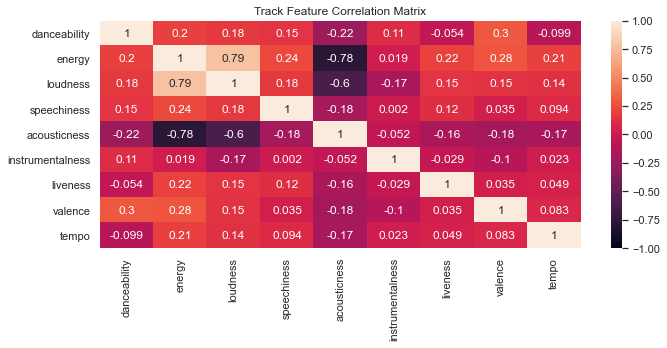

In [22]:
''' Check for multicollinearity between features '''

ppdata = data[features]

fig, ax = plt.subplots(1, figsize=(10, 5))

sns.heatmap(ppdata.corr(), ax=ax, vmin=-1, vmax=1, annot=True)
plt.title('Track Feature Correlation Matrix')

plt.tight_layout()
plt.show()

## Model Building
<b>General solution:</b> Since I am predicting multiple classes, build multiple binary classifiers (one per class) to run in parallel that each predict whether each song does / does not belong to one class. 

<b>Evaluation Metrics:</b>
- Microaveraged F1, precision, recall: because dataset has multiple classes, TP, TN, FP, and FN will be summed across all classes to compute precision, recall, and f1 to account for class imbalances.
Note: Taking the use case into consideration, it is better for the end user to receive a smaller playlist with a higher percentage of correct entries
than a larger playlist with more erroneous entries. Therefore, a greater emphasis should be placed on maximizing TP / FP ratio while maintaining a reasonable
enough TN / FN ratio to generate a substantial playlist. In other words, 

<b>Model selected: Logistic Regression</b>  
Logistic Regression has high flexibility in the decision threshold, as I can adjust the probability threshold at which it predicts whether a track belongs to a class or not. This is important for my use case, as it allows me to optimize the threshold for higher precision (at the cost of recall) by increasing the threshold from default 0.5 to make the classifier more "selective". Further, the model has extremely high explainability, which is always a benefit.

In [23]:
binarizer = binarize(df=data_wtrackid, feature_var='genre', label_var='label', id_col='trackid')
model_data = binarizer['data']

X = model_data[features + binarizer['genre']]
y = model_data[binarizer['label']]

In [24]:
'''Prepare Data'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
scaler = preprocessing.StandardScaler()
X_train_transformed = np.concatenate((scaler.fit_transform(X_train[features]), X_train[binarizer['genre']].to_numpy()), axis=1)
X_test_transformed = np.concatenate((scaler.fit_transform(X_test[features]), X_test[binarizer['genre']].to_numpy()), axis=1)

   threshold  precision    recall        f1
0        0.1   0.688160  0.975875  0.807144
1        0.2   0.770622  0.949812  0.850885
2        0.3   0.821295  0.922132  0.868798
3        0.4   0.862603  0.894561  0.878291
4        0.5   0.891654  0.860635  0.875870
5        0.6   0.916617  0.825202  0.868511
6        0.7   0.936516  0.775337  0.848338
7        0.8   0.956985  0.706839  0.813108
8        0.9   0.977962  0.597415  0.741726


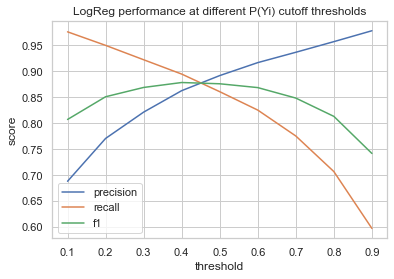

In [25]:
'''Logistic Regression with adjusted probability threshold'''
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
multilogreg.fit(X_train_transformed, y_train)

micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')
scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'f1': micro_f1}

pred_proba_df = pd.DataFrame(multilogreg.predict_proba(X_train_transformed))

threshold_scores = pd.DataFrame({'threshold':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

for index, row in threshold_scores.iterrows():
    i = row['threshold']
    y_train_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)

    y_train_mat = y_train.to_numpy()
    y_train_pred_mat = y_train_pred.to_numpy()

    threshold_scores.at[index, 'precision'] = precision_score(y_train, y_train_pred, average='micro')
    threshold_scores.at[index, 'recall'] = recall_score(y_train, y_train_pred, average='micro')
    threshold_scores.at[index, 'f1'] = f1_score(y_train, y_train_pred, average='micro')

print(threshold_scores)

for col in ['precision', 'recall', 'f1']:
    sns.lineplot(data=threshold_scores, x='threshold', y=col, palette='rocket')
    plt.ylabel('score')
    plt.legend(['precision', 'recall', 'f1'])
    plt.title('LogReg performance at different P(Yi) cutoff thresholds')

## Analyzing Performance Results
As expected, increasing threshold led to a tradeoff between precision and recall. Setting the threshold at 0.8 keeps precision at an excellent level while keeping recall sufficiently high to generate a reasonably sized playlist. F1 score is still > 0.8 at this threshold, which is a good indicator of general model performance.

Design decision to move forward with <b>threshold = 0.8</b> for the Logistic Regression model.

In [32]:
'''Logistic Regression hyperparameter tuning'''
# Instantiate LogisticRegression classifier (estimator) for cross validation
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

# Perform grid search cross validation for hyperparameter tuning
micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')

parameters = {'estimator__C': [0.5, 1, 2, 3, 4, 5]}

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'micro_f1': micro_f1}
cv_score = {'micro_precision': micro_precision}

multilogreg_gs = GridSearchCV(multilogreg, parameters, refit=cv_score)
multilogreg_gs.fit(X_train_transformed, y_train)
print('Best combination: {0}\n'.format(multilogreg_gs.best_params_))

logreg_scores = cross_validate(multilogreg, X_train_transformed, y_train, scoring=scoring)
logreg_scores_optimal = cross_validate(multilogreg_gs.best_estimator_, X_train_transformed, y_train, scoring=scoring)

print('CV Scores Before Optimization:')
for key in logreg_scores:
    print('{0}: {1}'.format(key, logreg_scores[key]))

print('\nCV Scores After Optimization:')
for key in logreg_scores_optimal:
    print('{0}: {1}'.format(key, logreg_scores_optimal[key]))

Best combination: {'estimator__C': 2}

CV Scores Before Optimization:
fit_time: [1.0272851  1.49500394 1.42818356 1.09906292 1.25664186]
score_time: [0.01991796 0.01895046 0.01595926 0.02194166 0.01595736]
test_micro_precision: [0.89547233 0.89       0.88225446 0.89618406 0.88592098]
test_micro_recall: [0.86268174 0.86268174 0.85137318 0.86045259 0.85683531]
test_micro_f1: [0.87877126 0.87612797 0.86653878 0.87795492 0.87113543]

CV Scores After Optimization:
fit_time: [1.17786908 1.13297319 1.31647658 1.53589678 1.41721249]
score_time: [0.01393199 0.01296639 0.0329113  0.02792764 0.02294016]
test_micro_precision: [0.89520624 0.88993885 0.88195991 0.89535534 0.8856191 ]
test_micro_recall: [0.86483576 0.86214324 0.85298869 0.86206897 0.85844995]
test_micro_f1: [0.87975897 0.87582057 0.86723241 0.87839693 0.8718229 ]


Tuning on the C hyperparameter didn't lead to any major gains in precision or recall. 

## Comparing Logistic Regression performance with Random Forest Classifier
Keeping in mind I'm focused on precision over recall

In [34]:
# Instantiate RandomForest classifier (estimator) for cross validation
rf = RandomForestClassifier(n_estimators=100, random_state=0)
multirf = OneVsRestClassifier(rf, n_jobs=-1)

# Establish scoring metrics
micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'f1': micro_f1}
rf_scores = cross_validate(multirf, X_train_transformed, y_train, scoring=scoring)

print('CV Scores for Random Forest:')
for key in rf_scores:
    print('{0}: {1}'.format(key, rf_scores[key]))

CV Scores for Random Forest:
fit_time: [3.52457905 2.49532342 2.25397849 2.5751195  2.52824259]
score_time: [0.31116843 0.16555858 0.30817461 0.16757631 0.14863729]
test_micro_precision: [0.90950745 0.90435281 0.89903573 0.9053288  0.90992018]
test_micro_recall: [0.8551427  0.85029618 0.85352719 0.86045259 0.85898816]
test_f1: [0.88148765 0.87649181 0.87569061 0.88232044 0.88372093]


Random Forest Classifier is comparable with out-of-the-box Logistic Regression precision / recall performance at threshold = 0.5. However, Logistic Regression holds the advantage in its adjustable prediction threshold.